In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from helpers import (
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
)


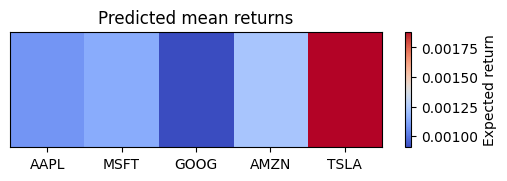

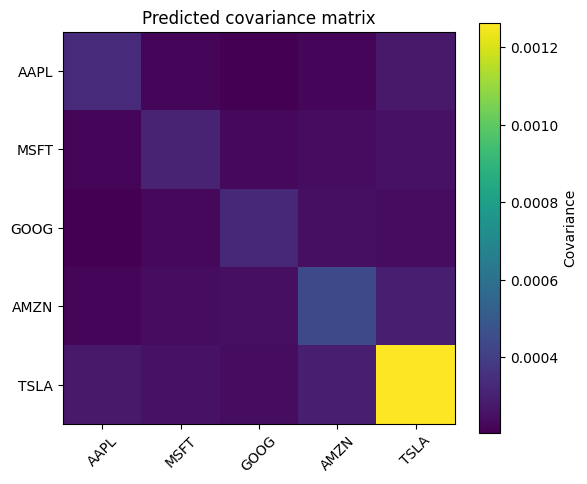

In [2]:
mu_hat, Sigma_hat, tickers = load_predictions("predicted.npz")
n = len(tickers)

plot_mu_and_cov(mu_hat, Sigma_hat, tickers)

#Task 0

In [3]:
n = Sigma_hat.shape[0]
w_equal = np.ones(n) / n

#Task 1.1

In [4]:
Sigma_inv = np.linalg.inv(Sigma_hat)
ones = np.ones(len(Sigma_hat))
numerator = Sigma_inv @ ones
denominator = ones.T @ Sigma_inv @ ones

w_minvar = numerator / denominator

#Task 1.2

In [5]:
def markowitz_portfolio(mu, Sigma, lam, gamma=2, u=1):
   
    n = len(mu)
    w = cp.Variable(n)

    expected_return = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    objective = cp.Maximize(expected_return - lam * risk)
    
    constraints = [
        cp.sum(w) == 1,           
        w >= 0,                   
        cp.norm(w, 1) <= gamma,    
        w <= u                   
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return w.value

#Task 2.1

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
C:\Users\abiji\AppData\Local\Temp\ipykernel_26968\3243746229.py:26: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='Risk Aversion ($\lambda$)')


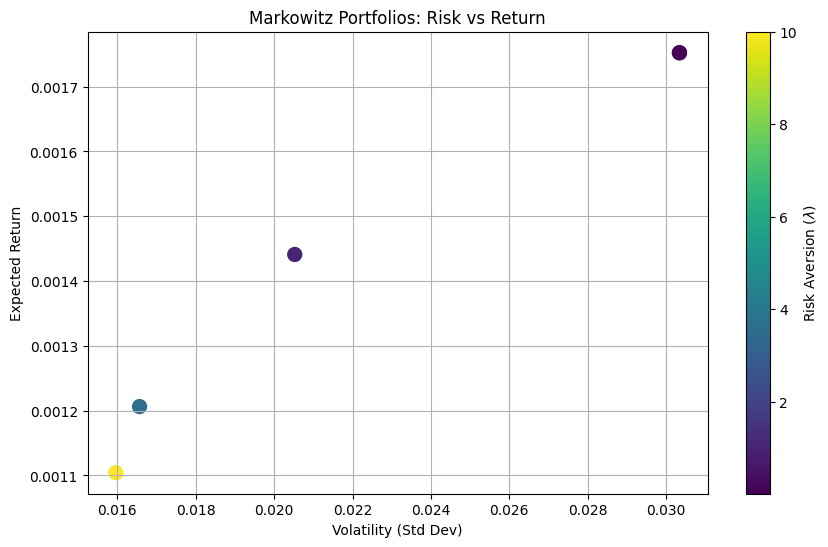

In [6]:
lams = [0.01, 0.1, 1.0, 3.5, 10.0]
gammas = [1.4, 1.6, 1.8]
us = [0.6, 0.8, 0.95]

gamma_base = 1.6
u_base = 0.8

results_weights = []
results_returns = []
results_variances = []

for lam in lams:
    w = markowitz_portfolio(mu_hat, Sigma_hat, lam, gamma=gamma_base, u=u_base)
    
    if w is not None:
        results_weights.append(w)
        results_returns.append(mu_hat.T @ w)
        results_variances.append(np.dot(w.T, np.dot(Sigma_hat, w)))

weights = np.array(results_weights)
returns = np.array(results_returns)
variances = np.array(results_variances)

plt.figure(figsize=(10, 6))
plt.scatter(np.sqrt(variances), returns, c=lams, cmap='viridis', marker='o', s=100)
plt.colorbar(label='Risk Aversion ($\lambda$)')
plt.title('Markowitz Portfolios: Risk vs Return')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.show()

#Task 2.2

In [7]:
def robust_markowitz(mu, Sigma, lam, eps):

    n = len(mu)
    w = cp.Variable(n)

    expected_return = mu.T @ w
    robust_penalty = eps * cp.norm(w, 2)
    risk = lam * cp.quad_form(w, Sigma)
    
    objective = cp.Maximize(expected_return - robust_penalty - risk)

    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return w.value

#Task 3.1

<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:46: SyntaxWarning: invalid escape sequence '\e'
C:\Users\abiji\AppData\Local\Temp\ipykernel_26968\1419130102.py:46: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Portfolio Return Distribution under $L_2$ Perturbations ($\epsilon={eps}$)')


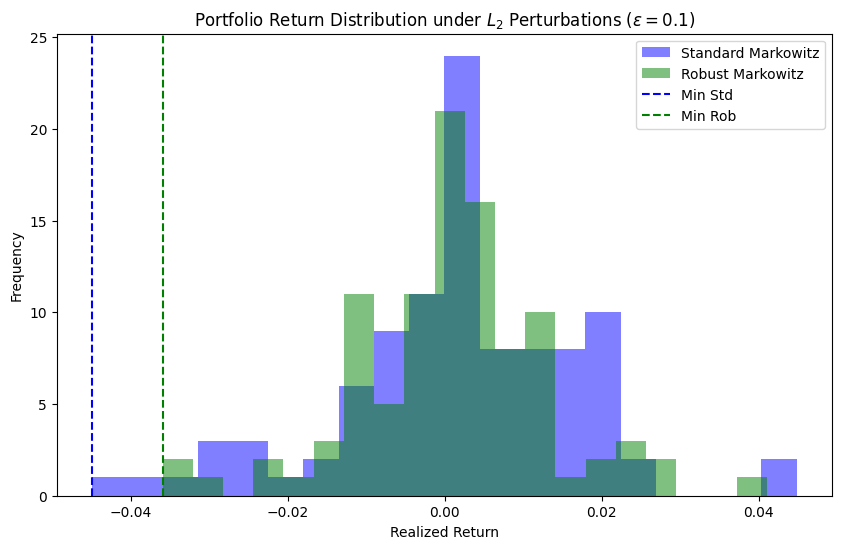

Statistic  | Standard   | Robust    
-----------------------------------
Mean       | 0.0017     | 0.0010    
Median     | 0.0015     | 0.0014    
Worst (Min) | -0.0449    | -0.0360   


In [8]:
lam = 1.2
eps = 0.1
num_samples = 100
n = len(mu_hat)

w_std = markowitz_portfolio(mu_hat, Sigma_hat, lam)
w_rob = robust_markowitz(mu_hat, Sigma_hat, lam, eps)

def sample_l2_perturbations(n, eps, num_samples, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    deltas = []
    radii = []
    for _ in range(num_samples):
       
        u = np.random.randn(n)
        u = u / np.linalg.norm(u) 
        
        r = np.random.uniform(0, eps)
        
        deltas.append(r * u)
        radii.append(r)

    return np.array(deltas), np.array(radii)

deltas, _ = sample_l2_perturbations(n, eps, num_samples, seed=42)

ret_std = []
ret_rob = []

for delta in deltas:
    mu_perturbed = mu_hat + delta
    ret_std.append(mu_perturbed @ w_std)
    ret_rob.append(mu_perturbed @ w_rob)

ret_std = np.array(ret_std)
ret_rob = np.array(ret_rob)

plt.figure(figsize=(10, 6))
plt.hist(ret_std, bins=20, alpha=0.5, label='Standard Markowitz', color='blue')
plt.hist(ret_rob, bins=20, alpha=0.5, label='Robust Markowitz', color='green')
plt.axvline(np.min(ret_std), color='blue', linestyle='--', label='Min Std')
plt.axvline(np.min(ret_rob), color='green', linestyle='--', label='Min Rob')
plt.title(f'Portfolio Return Distribution under $L_2$ Perturbations ($\epsilon={eps}$)')
plt.xlabel('Realized Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"{'Statistic':<10} | {'Standard':<10} | {'Robust':<10}")
print("-" * 35)
print(f"{'Mean':<10} | {np.mean(ret_std):<10.4f} | {np.mean(ret_rob):<10.4f}")
print(f"{'Median':<10} | {np.median(ret_std):<10.4f} | {np.median(ret_rob):<10.4f}")
print(f"{'Worst (Min)':<10} | {np.min(ret_std):<10.4f} | {np.min(ret_rob):<10.4f}")

#Task 4.2